## Initial data
Initial constants and derived data. Assumes ender pearl is in 1st quadrant

In [1]:
# Allowed coordinate of wind charge (1-axis, including mirrored copies)
windChargeCoord = [
0.72875,
0.79125,
0.03125,
0.27125,
0.20875,
0.96875,
]

# Allowed coordinate of pearl (1-axis)
enderPearlCoord = [
    0.0625,
    # 0.24,
    # 0.3025,
]

# Max distance from pearl to axis to count them as collinear (units - blocks)
collinearDistThreshold = 1E-6
# Max error in distance ratio to count pearl as being in center of axis (units - fraction)
axisCenterRatioError = 0.01
# Max angle error between two axis from 90 deg (units - deg)
axisOrthogErrorDeg = 0.1

from itertools import product

# List of all possible wind charge coords, for all 4 quadrants in order (1st..4th -> 0..3)
windChargePosQuads = []
windChargePosQuads.append(list(product(windChargeCoord, repeat=2)))
windChargePosQuads.append([(-x,  y) for (x, y) in windChargePosQuads[0]])
windChargePosQuads.append([(-x, -y) for (x, y) in windChargePosQuads[0]])
windChargePosQuads.append([( x, -y) for (x, y) in windChargePosQuads[0]])

# List of all possible ender pearl positions
enderPearlPosArr = list(product(windChargeCoord, repeat=2))

## Shared functions

In [2]:
import numpy as np

from itertools import product
from math import hypot

# (caution, made by ai)
def pointToLineDistance(P, A, B):
    x0, y0 = P
    x1, y1 = A
    x2, y2 = B
    numerator = abs((x2 - x1)*(y1 - y0) - (x1 - x0)*(y2 - y1))
    denominator = hypot(x2 - x1, y2 - y1)
    return numerator / denominator

def pointToPointDist(A, B):
    x1, y1 = A
    x2, y2 = B
    return hypot(x2 - x1, y2 - y1)

# Try all combinations of wind charge and ender pearl positions
def getValidAxisList(posAList, posBlist, targetList):
    
    validCombos = []
    for pointCombo in product(posAList, posBlist, targetList):
        (chargeAPos, chargeBPos, pearlPos) = pointCombo
        colinError = pointToLineDistance(pearlPos, chargeAPos, chargeBPos)
        if abs(colinError) < abs(collinearDistThreshold):
            distAP = pointToPointDist(chargeAPos, pearlPos)
            distBP = pointToPointDist(chargeBPos, pearlPos)
            distRatio = distAP / distBP
            if (distRatio <= (1.0 + axisCenterRatioError)) and (distRatio >= (1.0 - axisCenterRatioError)):
                # Found pair of values with pearl in the center between them
                validCombos.append(pointCombo)
    
    return validCombos

# (caution - made by ai)
def angleBetweenLinesDeg(A, B, C, D):
    # Convert points to vectors
    u = np.array(B) - np.array(A)
    v = np.array(D) - np.array(C)

    # Compute dot product and magnitudes
    dot_product = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)

    # Compute angle in radians and convert to degrees
    cos_theta = dot_product / (norm_u * norm_v)
    angle_rad = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip for numerical stability
    angle_deg = np.degrees(angle_rad)

    return angle_deg

## Axis search
### First axis ("X")
Find all point pairs that cross ender pearl position. Points are in 1st and 3rd quadrant

In [3]:
validAxis1 = getValidAxisList(windChargePosQuads[0], windChargePosQuads[2], enderPearlPosArr)

### Second axis ("Y")
Same for 2nd and 4th quadrants

In [4]:
validAxis2 = getValidAxisList(windChargePosQuads[1], windChargePosQuads[3], enderPearlPosArr)

## Axis matching
Need to find matching pairs of axis

In [5]:
from itertools import product
from math import atan2, degrees

axisCandidates = []
for axisPair in product(validAxis1, validAxis2):
    (axis1, axis2) = axisPair
    pearl1 = axis1[2]
    pearl2 = axis2[2]
    if pearl1 == pearl2:
        # See if axis are 90 deg apart
        axisAngleDeg = angleBetweenLinesDeg(axis1[0], axis1[1], axis2[0], axis2[1])
        if abs((abs(axisAngleDeg) - 90)) < axisOrthogErrorDeg:
            # Axis are pretty orthogonal. Save data
            axisCandidates.append(axisPair)


## Graphical wrapper


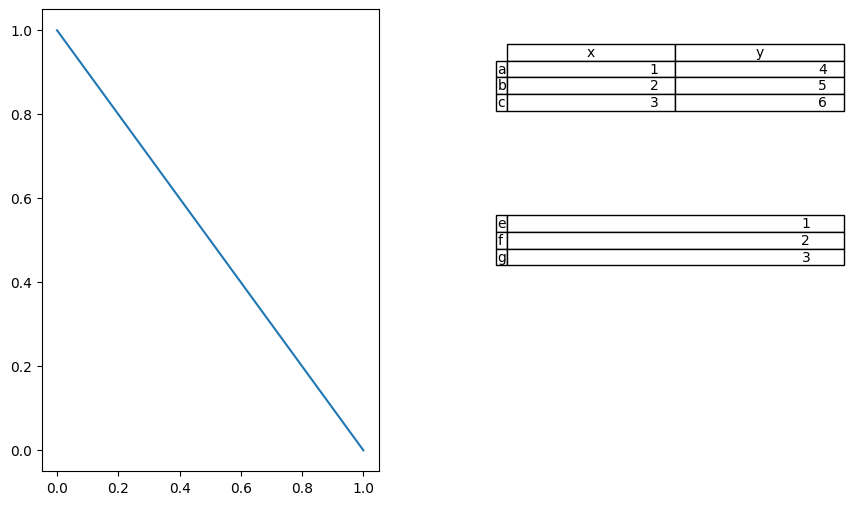

In [6]:
# TEST

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9, 6))
pltSubfigs = fig.subfigures(1, 2, wspace=0.07)
graphPlt = pltSubfigs[0].add_subplot() 
graphPlt.plot((0, 1), (1, 0))

tablePlts = pltSubfigs[1].subplots(3, 1, sharex=True)
tablePlts[0].set_axis_off()
tablePlts[0].table(cellText=[[1, 4], [2, 5], [3, 6]], rowLabels=("a", "b", "c"), colLabels=("x", "y"), loc="center")
tablePlts[1].set_axis_off()
tablePlts[1].table(cellText=[[1], [2], [3]], rowLabels=("e", "f", "g"), loc="center")
tablePlts[2].set_axis_off()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown

def plotResult(index):
    fig = plt.figure(figsize=(12, 9))
    pltSubfigs = fig.subfigures(1, 2, width_ratios=(2, 1), wspace=0.1)
    
    # First plot graphical data
    plotSide = pltSubfigs[0].add_subplot()
    axisPair = axisCandidates[index]
    for (windA, windB, pearl) in axisPair:
        xVals = (windA[0], windB[0])
        yVals = (windA[1], windB[1])
        # Plot solid black line, point marker
        plotSide.plot(xVals, yVals, ".-k", linewidth=1)
        # Plot ender pearl (red plus), every time just in case
        plotSide.plot(pearl[0], pearl[1], "+r")
    plotSide.axhline(0, color="lightgray")
    plotSide.axvline(0, color="lightgray")
    plotSide.set_title(f"Total matches: {len(axisCandidates)}")
    plotSide.set_xlabel("X")
    plotSide.set_ylabel("Z")
    plt.show()
    
    tableSubplots = pltSubfigs[1].subplots(2, 1, sharex=True)
    for id, (windA, windB, pearl) in enumerate(axisPair):
        tableSubplots[id].set_title(f"Axis {id+1}")
        tableSubplots[id].set_axis_off()
        pointsDist = pointToPointDist(windA, windB)
        distPearlToA = pointToPointDist(windA, pearl)
        distPearlToB = pointToPointDist(windB, pearl)
        pearlOffs = pointToLineDistance(pearl, windA, windB)
        colLbls = ["Property name", "X", "Z"]
        rowNames = ["Point A", "Point B", "Pearl", "Length total", "Length to A", "Length to B", "Pearl offset from line"]
        cellVals = [windA, windB, pearl, (pointsDist, "-"), (distPearlToA, "-"), (distPearlToB, "-"), (pearlOffs, "-")]
        combinedRowData = [(descr, vals) for descr, vals in zip(rowNames, cellVals)]
        tableSubplots[id].table(cellText=cellVals, rowLabels=rowNames, colLabels=colLbls, loc="upper center")
    
        display(Markdown(f"### **Axis {id+1}**"))
        

selector = widgets.IntSlider(
    value=0,
    min=0,
    max=len(axisCandidates) - 1,
    step=1,
    description='View Index:',
    continuous_update=False
)

axisViewer = widgets.interact(plotResult, index=selector)
display(axisViewer)


interactive(children=(IntSlider(value=0, continuous_update=False, description='View Index:', max=5), Output())…

<function __main__.plotResult(index)>